# Восстановление золота из руды

В этом проекте мы подготовим прототип модели машинного обучения для компании «Цифры». Компания разрабатывает технологические решения для задач крупных промышленных предприятий.

Модель должна будет предсказать коэффициент восстановления золота из золотосодержащей руды на разных этапах очистки сырья. В качестве признаков для обучения будет использоваться информация с датчиков, фиксирующих концентрации веществ на разных этапах технологического процесса.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Технологический процесс состоит из нескольких этапов:
* Флотация (в исходное сырье добавляются специальные реагенты, а также вода и воздух с целью разделения смеси на частицы драгоценных металов и прочие примеси).
* Первичная и вторичная очистка (полученная на этапе флотация пульпы очищается для увеличения концентрации драгоценных металлов).

Данные, с которыми предстоит работать, представляют собой различные параметры сырья (`input`) и продукта (`output`) c каждого этапа, а также различные физико-химические характеристики с каждой флотационной установки.

## Подготовительный этап

### Импорт библиотек


In [1]:
# отключим всякие предупреждения
import warnings
warnings.filterwarnings('ignore')

# визуализация
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# предобработка данных
import numpy as np
import pandas as pd
from scipy.stats import zscore

# машинное обучения
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

# фиксируем случайность
from numpy.random import RandomState
RANDOM_STATE=17

### Знакомство с данными

In [2]:
try:
    df_full = pd.read_csv('datasets/gold_recovery_full_new.csv')
    df_train = pd.read_csv('datasets/gold_recovery_train_new.csv') 
    df_test = pd.read_csv('datasets/gold_recovery_test_new.csv')
except FileNotFoundError:
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv') 
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [3]:
pd.set_option('display.max_columns', None)
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [4]:
def data_welcome(data):
    print(f'Размер набора данных: {data.shape}\n')
    print(f'Количество явных дубликатов: {data.duplicated().sum()}\n')
    data.info(show_counts=True, verbose=True)

In [5]:
data_welcome(df_full)

Размер набора данных: (19439, 87)

Количество явных дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.out

In [6]:
data_welcome(df_train)

Размер набора данных: (14149, 87)

Количество явных дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.out

In [7]:
data_welcome(df_test)

Размер набора данных: (5290, 53)

Количество явных дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.sta

Проверим совпадают ли названия и количество признаков в исходных данных и обучающей выборке:

In [8]:
df_full.columns.equals(df_train.columns)

True

Преобразуем признак даты к типу `datetime`

In [9]:
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')

In [10]:
# функция выводит имя переменной
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [11]:
for df in [df_full, df_train, df_test]:
    print(namestr(df, globals())[0])
    print(df['date'].describe(), '\n')

df_full
count                   19439
unique                  19439
top       2016-01-15 00:00:00
freq                        1
first     2016-01-15 00:00:00
last      2018-08-18 10:59:59
Name: date, dtype: object 

df_train
count                   14149
unique                  14149
top       2016-01-15 00:00:00
freq                        1
first     2016-01-15 00:00:00
last      2018-08-18 10:59:59
Name: date, dtype: object 

df_test
count                    5290
unique                   5290
top       2016-09-01 00:59:59
freq                        1
first     2016-09-01 00:59:59
last      2017-12-31 23:59:59
Name: date, dtype: object 



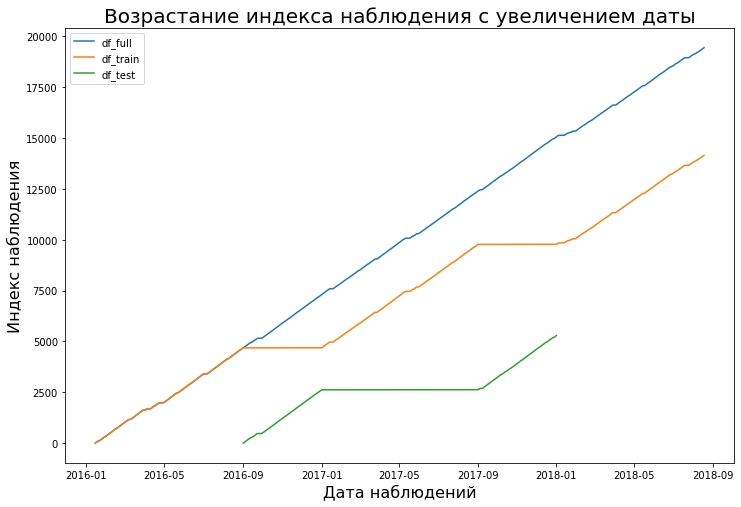

In [12]:
plt.figure(figsize=(12,8))

for df in [df_full, df_train, df_test]:
    sns.lineplot(df['date'], y=df.index, label=namestr(df, globals())[0])
plt.title('Возрастание индекса наблюдения с увеличением даты', fontsize=20)
plt.xlabel('Дата наблюдений', fontsize=16)
plt.ylabel('Индекс наблюдения', fontsize=16)
plt.legend();

#### Вывод
* Каждая строка датафрейма представляет собой данные о технологическом процессе на производстве индексированные за 1 час. 
* Для исходных данных и обучающей выборки временной период начинается 15 января 2016 года и заканчивается 18 августа 2018 года (~2,5 года).
* Исходные данные разделены на тестовую и обучающую выборку не случайным образом, а с помощью выделенных периодов, которые мы визуализировали на графике:
    * В тестовую выборку вошли данные примерно с сентября 2016 по январь 2017 и с сентября 2017 по январь 2018;
    * В обучающую выборку, соответственно, все остальные данные.
* Процесс флотации происходит в 10-й и 11-й флотационной установках;
* Процесс первичной очистки происходит в 8-й флотационной установке;
* Процесс вторичной очистки происходит в 2-6 флотационной установках.

### Предобработка данных

#### Расчет эффективности обогащения

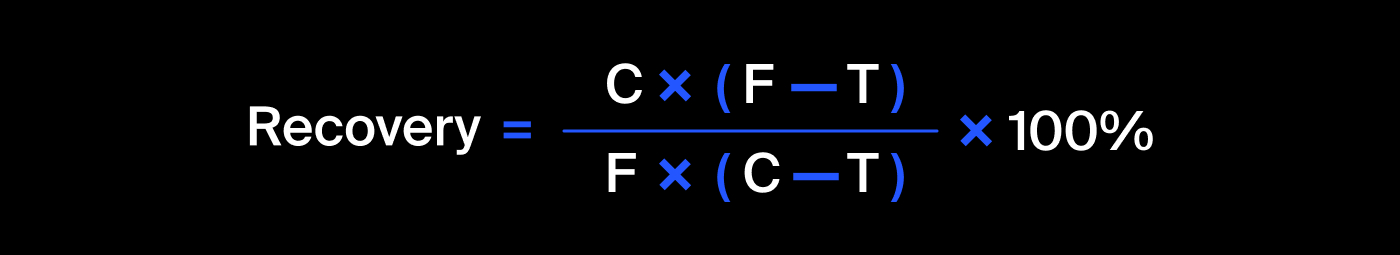
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

In [14]:
def recovery_score(data):
    # доля золота в сырье до очистки    
    au_ratio_before = data['rougher.input.feed_au']
    
    # доля золота в концентрате после очистки
    au_ratio_after = data['rougher.output.concentrate_au']
    
    # доля золота в отвальных хвостах
    au_ratio_tail = data['rougher.output.tail_au']
    
    
    recovery = (au_ratio_after * (au_ratio_before - au_ratio_tail)
               ) / (au_ratio_before * (au_ratio_after - au_ratio_tail))*100
    return recovery

In [15]:
mean_absolute_error(df_train['rougher.output.recovery'], recovery_score(df_train))

9.73512347450521e-15

##### Вывод
* В обучающей выборке эффективность обогащения для этапа флотации расчитана верно;
* Данные подтверждены с помощью метрики МАЕ, рассчитанной при сравнении признака `rougher.output.recovery` в исходных данных с вычислениями по известной формуле для *Recovery*.

#### Отсутствующие признаки в тестовой выборке

Как мы уже знаем, в тестовой выборке у нас всего 53 столбца, когда в обучающей и в сырых данных 87 столбцов.
Посмотрим, какие столбцы отсутствуют в тестовой выборке.

In [16]:
print('Разница в количестве столбцов между обучающей и тестовой выборкой:',
      len(set(df_train.columns) - set(df_test.columns)))

Разница в количестве столбцов между обучающей и тестовой выборкой: 34


In [17]:
missing_columns_in_test = set(df_train.columns) - set(df_test.columns)
missing_columns_in_test

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Вывод**
* Отсутствуют все столбцы, характеризующие параметры **продукта** на каждом этапе.
* А также рассчетные столбцы для этапа флотации (`rougher.calculation`) - значит эти параметры рассчитываются значительно позже.

#### Добавление целевых признаков в тестовую выборку

Так как нам понадобится замерять на тестовой выборке метрики качества, то необходимо добавить целевые признаки в тестовую выборку.

**Следующая ячейка добавляет целевые признаки в тестовую выборку:**
1. Сперва создаем сущности `target_columns_for_test` и `target_idx_for_test` для хранения названий столбцов и индексов недостающих в тестовой выборке величин.
2. В тестовой выборке в качестве индекса ставим дату (далее по дате, как по ключу, будем брать наблюдения из исходных данных).
3. В тестовую выборку добавляем столбцы с целевыми признаками и заполняем их значениями из исходных данных.
4. Возвращаем обычный индекс для тестовой выборки.

In [18]:
target_columns = list(set(df_full.columns) - set(df_test.columns))
target_idx_for_test = df_test.set_index('date').index

df_test = df_test.set_index('date')

df_test[target_columns] = df_full.set_index('date').loc[target_idx_for_test, target_columns]

df_test = df_test.reset_index()

In [19]:
df_test.head(3)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_ag,final.output.concentrate_pb,rougher.output.tail_sol,rougher.output.concentrate_pb,final.output.concentrate_sol,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.concentrate_ag,rougher.calculation.sulfate_to_au_concentrate,rougher.output.concentrate_sol,primary_cleaner.output.concentrate_pb,rougher.output.tail_au,final.output.tail_au,primary_cleaner.output.tail_pb,rougher.output.tail_pb,primary_cleaner.output.tail_au,final.output.tail_pb,final.output.tail_sol,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,secondary_cleaner.output.tail_pb,primary_cleaner.output.tail_ag,final.output.concentrate_au,secondary_cleaner.output.tail_au,final.output.concentrate_ag,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_sol,final.output.tail_ag,primary_cleaner.output.tail_sol,rougher.output.tail_ag,secondary_cleaner.output.tail_sol,primary_cleaner.output.concentrate_au,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,16.484844,10.466295,14.787965,8.227045,11.990938,2102.438804,22.186207,89.993421,15.734654,35236.090448,33.791932,12.706851,2.371757,4.537988,4.148198,0.747425,6.587571,3.844413,11.075686,2173.703032,2.143822,4.413600,17.266279,40.743891,5.560988,7.578381,11.631910,17.872038,12.688885,11.034524,5.936471,12.034406,28.364867,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,

In [20]:
df_test.isna().sum().sort_values(ascending=False)

secondary_cleaner.output.tail_sol         143
primary_cleaner.output.concentrate_sol     84
primary_cleaner.output.concentrate_pb      30
rougher.input.floatbank11_xanthate         25
rougher.input.feed_sol                     21
                                         ... 
rougher.state.floatbank10_e_level           0
rougher.state.floatbank10_e_air             0
rougher.state.floatbank10_d_level           0
rougher.state.floatbank10_d_air             0
final.output.recovery                       0
Length: 87, dtype: int64

#### Обработка выбросов

Выбросы могут сильно сказаться на качестве обучения нашей модели, поэтому важно обратить на них внимание еще на этапе предобработки.
Посмотрим на описательные статистики столбцов, содержащих ключевые признаки - концентрации веществ на разных этапах.

In [21]:
concentrate_columns = [col for col in df_train.columns if col.endswith(('_au', '_ag', '_pb', '_sol'))]
print('Количество столбцов с концентрацией:', len(concentrate_columns))
df_train[concentrate_columns].describe()

Количество столбцов с концентрацией: 32


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14149.000000,14049.000000,14071.000000,14149.000000,14149.000000,14149.000000,14127.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000
mean,5.142034,10.132960,9.202849,44.003792,9.607035,2.597298,10.512122,2.918421,8.200916,9.588862,10.114745,32.386836,16.303929,3.443398,7.533566,3.839637,8.579195,3.522778,36.312593,7.866577,11.775812,7.664555,28.302715,19.439958,5.567124,0.653277,17.882853,1.757473,14.281629,5.848863,6.938693,4.246961
std,1.369586,1.654930,2.790516,4.905261,2.319069,0.971843,3.003617,0.903712,2.005185,2.694296,4.064076,5.798843,3.739843,1.490106,2.133220,1.603544,1.896284,1.073394,4.956057,1.919506,2.731747,1.856279,6.102982,3.765192,1.039136,0.263766,3.432859,0.713187,4.477126,2.861799,4.155487,2.389060
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.594562,0.007566,10.014648,0.020676,0.000000,0.000000,0.000000,0.000000
25%,4.211620,9.297355,7.484645,43.276111,7.997429,1.905973,8.811324,2.368607,7.107126,8.333489,7.488139,30.857764,13.873147,2.420259,6.332548,2.867957,7.132802,2.780010,34.117635,6.596217,10.486871,6.850501,26.703554,18.432161,4.921647,0.474047,15.688727,1.310800,12.177364,3.982298,3.225486,3.153122
50%,4.994652,10.297144,8.845462,44.872436,9.480270,2.592022,10.514621,2.851025,8.226247,9.933520,9.726566,33.225835,15.800604,3.218374,7.714419,3.510337,8.156092,3.422677,37.020345,7.649138,11.747362,7.760435,29.257545,19.947312,5.722018,0.625805,18.015894,1.745513,15.357951,5.442310,7.302639,3.980210
75%,5.859540,11.170603,10.487508,46.166425,11.003707,3.241723,11.933009,3.434764,9.504924,11.310817,13.052807,35.330145,18.450109,4.253218,8.910664,4.492470,9.918304,4.226107,39.423265,9.066976,13.426419,8.601927,31.743913,21.392714,6.310633,0.794326,19.938672,2.186790,17.230151,7.797948,10.547068,4.883943
max,16.001945,17.031899,18.124851,52.756638,19.552149,5.639565,22.317730,8.197408,16.081632,17.081278,22.280845,45.933934,29.459575,9.634565,20.620833,17.788925,14.596026,7.142594,48.363177,13.126043,24.480271,13.617072,38.351193,28.146838,12.719177,3.778064,66.117188,9.688980,23.264738,17.042505,17.976171,26.811643


* Как видим, у каждого признака есть сильные выбросы как в меньшую, так и в большую сторону.
* Для корректности дальнейшней работы модели воспользуемся правилом трёх сигм (*вероятность отклониться далее 3-х сигм для нормально распределенной величины очень мала (0,28%)*) и удалим все значения, выходящие за границы этого диапазона. 
* Сюда попадут и аномально маленькие значения (например, 0) и аномально большие. Будем считать, что всего это просто ошибки в работе измерительных приборов.

Следующая функция предназначена для замены выбросов в каждом столбце на NaN:
* Принимает на вход датафрейм
* Создает новый пустой датафрейм, который в цикле будет наполняться обработанными значениями из старого.
* Итерируется по столбцам старого датафрейма, возвращая только те значения, которые укладываются в +- 3 стандартных отклонения своего же столбца.
* Возвращает новый датафрейм.

In [22]:
def drop_outliers(df):
    df_new = pd.DataFrame(columns=df.columns, index=df.index)
    for col in df.columns:
        df_new[col] = df[(abs(zscore(df[col], nan_policy='omit')) < 3)][col]
    return df_new

In [23]:
df_train[concentrate_columns] = drop_outliers(df_train[concentrate_columns])

#### Обработка пропусков

Посмотрим, в каких столбцах обучающей выборки у нас больше всего пропусков.

In [24]:
df_train.isna().sum().sort_values(ascending=False).head(10)

secondary_cleaner.output.tail_sol        1605
secondary_cleaner.output.tail_ag          750
rougher.state.floatbank10_e_air           436
rougher.input.floatbank11_xanthate        428
rougher.output.concentrate_sol            400
rougher.output.concentrate_au             335
rougher.output.concentrate_ag             332
primary_cleaner.output.concentrate_au     332
rougher.input.feed_sol                    319
primary_cleaner.output.concentrate_pb     314
dtype: int64

Очень много пропусков в `secondary_cleaner.output.tail_sol`.
* Возьмем у них индексы и посмотрим на близлежащие к ним строки.

In [25]:
df_train[df_train['secondary_cleaner.output.tail_sol'].isna()].index[:10]

Int64Index([1616, 1617, 1618, 1619, 1826, 1916, 2953, 3394, 3396, 4824], dtype='int64')

In [26]:
df_train.loc[1611:1622, [col for col in df_train.columns if 'sol' in col]]

,final.output.concentrate_sol,final.output.tail_sol,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_sol,rougher.input.feed_sol,rougher.output.concentrate_sol,rougher.output.tail_sol,secondary_cleaner.output.tail_sol
1611,7.137830,17.532141,12.422091,7.562996,34.918582,19.364745,17.342700,8.441815
1612,5.106734,17.413057,12.183826,7.450207,34.905715,19.254508,17.670894,9.060448
1613,5.255700,17.407608,12.589357,7.616487,35.031019,19.498017,17.568255,9.015720
1614,5.683586,17.310763,12.953219,7.515749,34.303565,19.478011,17.211380,9.116624
1615,3.441309,18.899253,10.747449,8.154663,NaN,16.510859,16.066635,11.823058
1616,NaN,4.265981,9.355665,1.689113,NaN,NaN,12.227496,NaN
1617,NaN,5.198314,NaN,1.715481,NaN,11.915832,13.050464,NaN
1618,NaN,6.867096,NaN,2.699547,NaN,10.630895,12.297166,NaN
1619,NaN,11.612120,NaN,4.258946,37.467000,17.974658,16.127500,NaN
1620,NaN,11.020926,NaN,5.163486,23.943987,11.193395,21.199708,8.031037


Очевидных взаимосвязей с пропусками не замечено, поэтому просто заполним их методом `ffill` (на место каждого пропуска встанет предшествующее непропущенное значение). В нашем случае это допустимо, так как все наблюдения расположены строго в хронологичном порядке.

Заполним пропуски таким методом и в тестовом датафрейме тоже.

In [27]:
df_train.fillna(method='ffill', inplace=True)

In [28]:
df_test.fillna(method='ffill', inplace=True)

Проверим заполнение пропусков

In [29]:
print(f'Суммарное количество пропусков в обучающей выборке: {df_train.isna().sum().sum()}')
print(f'Суммарное количество пропусков в тестовой выборке: {df_test.isna().sum().sum()}')

Суммарное количество пропусков в обучающей выборке: 0
Суммарное количество пропусков в тестовой выборке: 0


## Анализ данных

### Динамика концентрации металлов на разных этапах очистки

In [30]:
def metal_concentration(data: pd.DataFrame, metal: str) -> pd.DataFrame:
        
    metal_cols = [col for col in df_train.columns 
                  if str('concentrate_' + metal) in col or str('feed_' + metal) in col]
    
    df_to_visualize = data[metal_cols]
    
    new_names = {}
    for i in df_to_visualize.columns:
        if 'rougher.input' in i:
            new_names[i] = '0_Исходное сырье'
        elif 'rougher.output' in i:
            new_names[i] = '1_Флотация'
        elif  'primary_cleaner.output' in i:
            new_names[i] = '2_Первичная очистка'
        elif 'final.output' in i:
            new_names[i] = '3_Вторичная очистка'
        else:
            new_names[i] = 'Unknown'
    df_to_visualize.rename(columns=new_names, inplace=True)
    df_to_visualize = df_to_visualize.reindex(sorted(df_to_visualize.columns), axis=1)
    
    return df_to_visualize

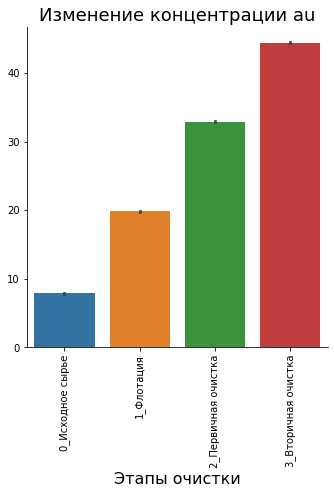

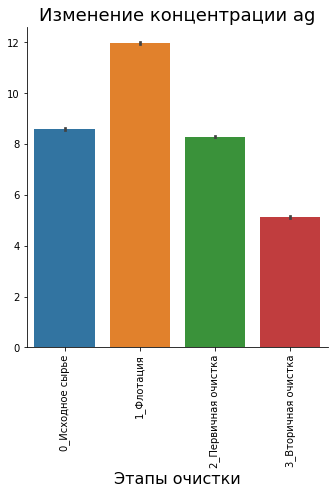

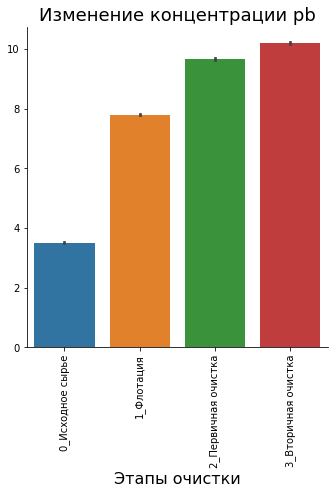

In [31]:
metals = ['au', 'ag', 'pb']
for i in metals:
    sns.catplot(data=metal_concentration(df_train, i), 
                kind='bar', ci = 95, estimator=np.mean);

    plt.xlabel("Этапы очистки", fontsize=16)
    plt.xticks(rotation=90)
    plt.title(f'Изменение концентрации {i}', fontsize=18);

#### Вывод

* Концентрация золота линейно увеличивается, возрастая примерно в 5 раз к стадии вторичной очистки по сравнению с концентрацией в исходном сырье.
* Концентрация серебра увеличивается после этапа флотации примерно на 50% и затем снижается к этапу вторичной очистки.
* Концентрация свинца после первого же этапа (флотации) увеличивается в 2 раза, затем постепенно нарастает до завершения всех этапов очистки.
* Однако, в абсолютных значениях концентрации, после финальной очистки, золота мы получаем в 9 раз больше, чем серебра и в 4.5 раза больше, чем свинца. 

### Распределения размеров гранул сырья на обучающей и тестовой выборках

Сравним распределения размеров частиц сырья на двух наших выборках: обучающей и тестовой. Если они сильно отличаются, необходимо будет это учесть при обучении модели регрессии.

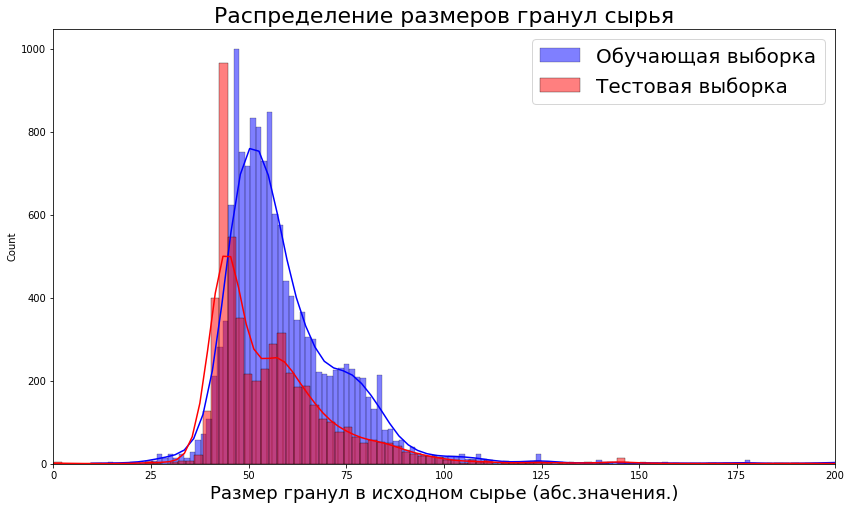

In [32]:
plt.figure(figsize=(14,8))
sns.histplot(df_train['rougher.input.feed_size'], color='b', alpha=0.5, kde=True, label='Обучающая выборка')
sns.histplot(df_test['rougher.input.feed_size'], color='r', alpha=0.5, kde=True, label='Тестовая выборка')
plt.xlim(0,200)
plt.title('Распределение размеров гранул сырья', fontsize=22)
plt.xlabel('Размер гранул в исходном сырье (абс.значения.)', fontsize=18)
plt.legend(prop={'size': 20});

#### Вывод

* Распределения размера гранул сырья отличаются незначительно - основная масса размеров частиц в обеих выборках находится в одном диапазоне, примерно от 35 до 95.
* В обеих выборках есть ярко выраженный пик в области значений 40-45
* В обеих выборках есть короткий хвост распределения слева (к нулю) и длинный справа (к 200 и далее до 500)

### Суммарная концентрация всех веществ на разных стадиях
Исследуем суммарную концентрацию всех веществ на разных стадиях: 
* в сырье, то есть до флотации 
* в черновом концентрате, то есть после флотации 
* в финальном концентрате, то есть после двух ступеней очистки

In [33]:
summary_conc_subs = pd.DataFrame()

summary_conc_subs['rougher_feed'] = df_train[['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_sol', 'rougher.input.feed_au']].sum(axis=1)
summary_conc_subs['draft_concentrate'] = df_train[[col for col in df_train.columns 
                                                   if 'rougher.output.con' in col]].sum(axis=1)
summary_conc_subs['draft_tails'] = df_train[[col for col in df_train.columns 
                                             if 'rougher.output.tail' in col]].sum(axis=1)
summary_conc_subs['final_concentrate'] = df_train[[col for col in df_train.columns 
                                                   if 'final.output.con' in col]].sum(axis=1)
summary_conc_subs['final_tails'] = df_train[[col for col in df_train.columns 
                                                   if 'final.output.tail' in col]].sum(axis=1)
summary_conc_subs['draft_full'] = summary_conc_subs[['draft_concentrate', 'draft_tails']].sum(axis=1)
summary_conc_subs['final_full'] = summary_conc_subs[['final_concentrate', 'final_tails']].sum(axis=1)

In [34]:
summary_conc_subs.drop(['draft_tails', 'final_tails'], axis=1, inplace=True)

In [35]:
summary_conc_subs.describe()

,rougher_feed,draft_concentrate,final_concentrate,draft_full,final_full
count,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000
mean,56.479560,68.521388,68.922871,94.315938,94.643684
std,6.343885,7.977476,3.830218,8.034226,5.990145
min,31.424559,25.605903,42.145304,47.553429,52.311216
25%,52.623525,65.056637,67.562020,90.345137,91.327805
50%,56.644242,69.234680,69.140939,95.097258,94.701709
75%,60.770018,73.481664,70.965139,99.673003,98.383032
max,74.458253,87.918479,79.622855,116.134975,110.668299


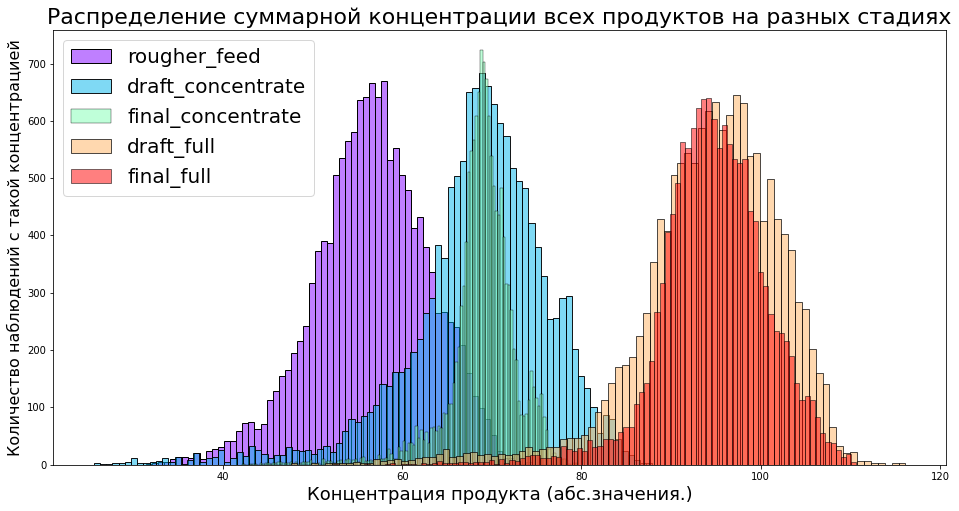

In [36]:
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(summary_conc_subs.columns)
                                       )
                           )
            )

plt.figure(figsize=(16,8))
for column, color in zip(summary_conc_subs.columns, color):
    sns.histplot(summary_conc_subs[column], color=color, alpha=0.5, label=column)

plt.title('Распределение суммарной концентрации всех продуктов на разных стадиях', fontsize=22)
plt.xlabel('Концентрация продукта (абс.значения.)', fontsize=18)
plt.ylabel('Количество наблюдений с такой концентрацией', fontsize=16)
plt.legend(prop={'size': 16});

#### Вывод
Мы проанализировали распределение следующих величин: 
1. Суммарная концентрация веществ в исходном сырье
2. Суммарная концентрация веществ в черновом концентрате (после флотации)
3. Суммарная концентрация веществ в финальом концентрате (после двух этапов очистки)

И заметили, что:
* Каждая величина имеет распределение близкое к нормальному;
* На этапе исходного сырья концентрация веществ распределена вокруг 55;
* Тогда как в черновом и финальном концентрате распределение уже вокруг 67-68, при том в финальном концентрате распределение уже заметно уже - смесь становится чище, однороднее;
* Общий объем смеси, который мы не знаем, но о котором можем косвенно судить по увеличению концентрации веществ:
    * Объем уменьшается почти в 2 раза после стадии флотации и дальше стабилен, сырье становится более концентрированным;
    * Далее концентрация основных измеряемых веществ уже не меняется;
    * Сумма концентраций выделяемых веществ + хвостов примерно одинаковая как для чернового концентрата, так и для финального концентрата.

## Обучение модели

### Подготовка метрик

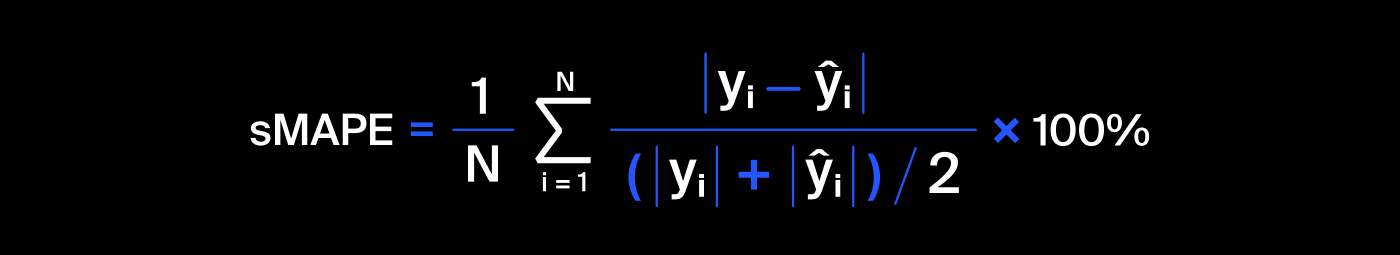
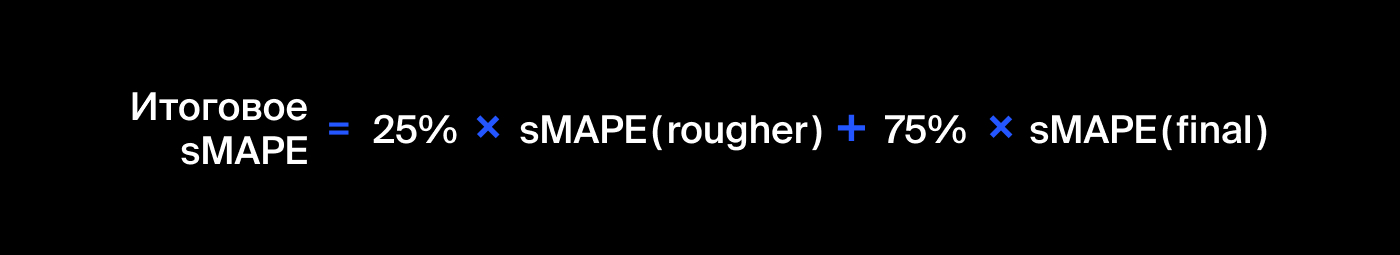

Наша ключевая метрика в этой задаче регрессии - **sMAPE** (симметричное среднее абсолютное процентное отклонение). В отличие от МАЕ она выражается не в абсолютных единицах, а в относительных (%), а также одинаково учитывает масштаб как целевого признака, так и предсказания.

При том **итоговая метрика sMAPE** складывается из:
* 1/4 метрики sMAPE для предсказаний этапа исходного сырья
* 3/4 метрики sMAPE для предсказаний финального этапа очистки

In [37]:
def smape(target, predictions) -> float:
    smape = sum(abs(target - predictions) / ((abs(target) + abs(predictions)) / 2)) / len(target)
    return smape*100

И сразу подготовим объект класса `scorer` для работы с моделями sklearn.

In [38]:
smape_score = make_scorer(smape, greater_is_better=False)

### Подготовка признаков для обучения и тестирования

Следующая функция принимает на вход датафрейм и разделяет на признаки для обучения (`features`) и целевые признаки (`target`).

In [39]:
def prepare_sample(data):
    features = data[list(set(data.columns) - missing_columns_in_test)]
    features = features.reindex(sorted(features.columns), axis=1)
    print('Размер датафрейма с features:', features.shape)
    target = data[['rougher.output.recovery', 'final.output.recovery']]
    target = target.reindex(sorted(target.columns), axis=1)
    print('Размер датафрейма с target:', target.shape)
    return features, target

**Обучающая выборка**

In [40]:
X_train, y_train = prepare_sample(df_train)

Размер датафрейма с features: (14149, 53)
Размер датафрейма с target: (14149, 2)


**Тестовая выборка**

In [41]:
X_test, y_test = prepare_sample(df_test)

Размер датафрейма с features: (5290, 53)
Размер датафрейма с target: (5290, 2)


### Проверка признаков на мультиколлинеарность

1. Создадим матрицу корреляции для всех признаков между собой
2. Отбросим признаки, имеющие коэффициент корреляции меньше 0.7 (-0.7), чтобы рассмотреть только сильные взаимосвязи
3. Визуализировать матрицу будем через heatmap, чтобы разгрузить график, исключим повторяющиеся значения над диагональю

In [42]:
corr_matrix = X_train.corr()
corr_matrix.shape

(52, 52)

In [43]:
corr_matrix_filtered =corr_matrix[
    ((corr_matrix[corr_matrix.columns] > 0.7)&
    (corr_matrix[corr_matrix.columns] < 1.0))|
    ((corr_matrix[corr_matrix.columns] > -1.0)&
    (corr_matrix[corr_matrix.columns] < -0.7))
    ].dropna(how='all').dropna(how='all', axis=1)
corr_matrix_filtered.columns = corr_matrix_filtered.columns.sort_values()

corr_matrix_filtered.shape

(37, 37)

In [44]:
mask = np.zeros_like(corr_matrix_filtered)
mask[np.triu_indices_from(mask)] = True

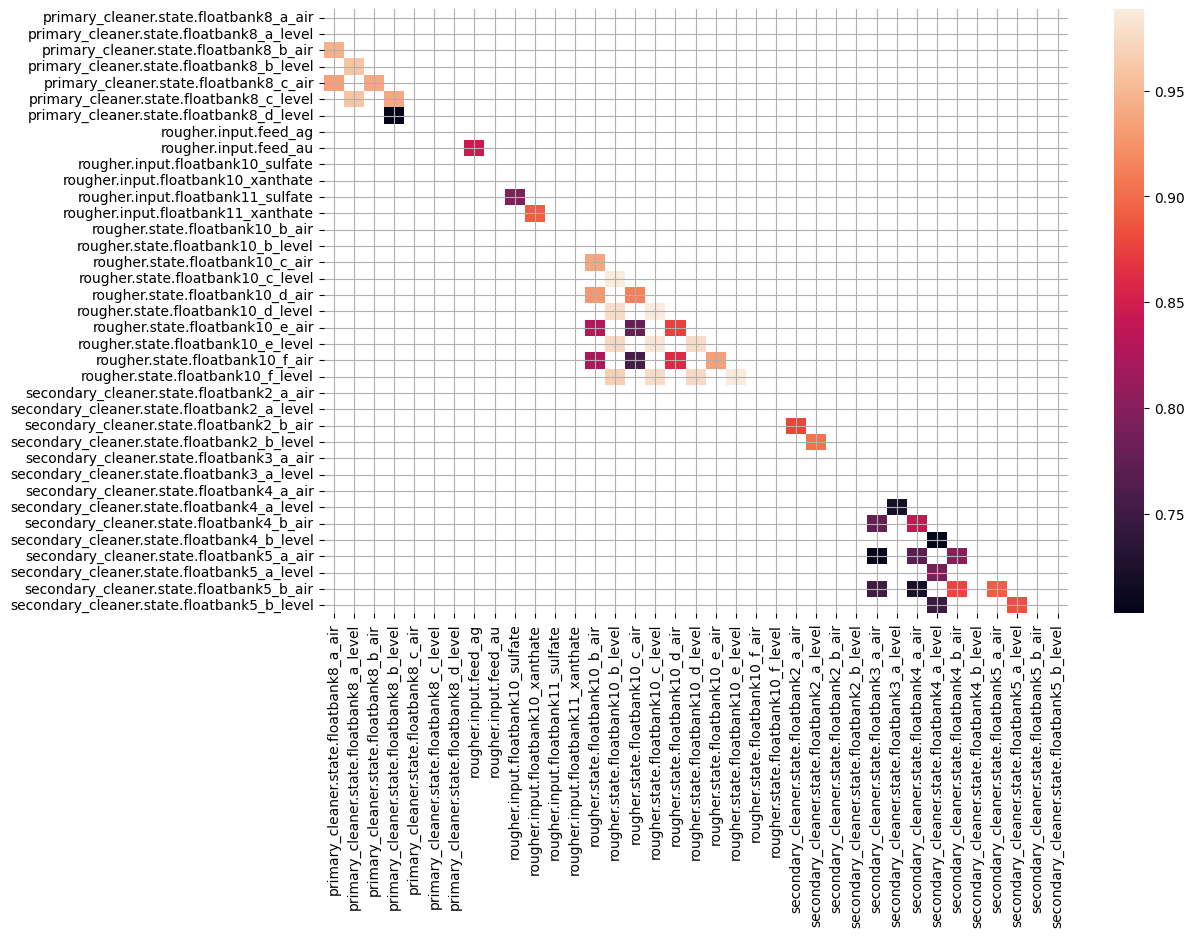

In [45]:
plt.figure(figsize=(12,8), dpi=100)
sns.heatmap(corr_matrix_filtered, mask=mask)
plt.grid(True)

#### Вывод

Рассмотрим выявленные взаимосвязи по порядку протекания технологического процесса, то есть сперва `rougher`, потом `primary_cleaner` и `secondary_cleaner`:
* Концентрация золота в исходном сырье сильно коррелирует с концентрацией серебра, вероятно это происходит потому, что богатые золотом руды, богаты и серебром.
* `rougher.input.floatbank11_sulfate` отражает концентрацию сульфата, взаимосвязь 10-й флотационной установки с 11-й неудивительна, скорее всего смесь переходит по установкам последовательно.
* `rougher.input.floatbank11_xanthate` скоррелирован с таким же параметром у 10-й установки, причина как и в предыдущем пункте
* Признак `state.floatbank` характеризует текущее состояние этапа (флотации, первичной очистки или вторичной очистки) в конкретной флотационной установке, а именно:
    * Какой уровень воды и объём воздуха находится сейчас во флотационной установке
    * Некий подпараметр в диапазоне **a-b-c-d-e-f** для этапа флотации, **a-b-c-d** для этапа первичной очистки и **a-b** для этапа вторичной очистки. ***Предположим, это порядковая маркировка измерения концентрации.*** То есть внутри установки в процессе флотации/очистки замеряли концентрацию воды/воздуха несколько раз и записывали под разными литерами.
    * Чем ближе эти маркировки одной флотационной установки друг к другу, тем сильнее корреляция между уровнями воды или воздуха. То есть, связь сильнее между **a и b**, чем между **a и c**. 
    
    
Таким образом, для борьбы с мульиколлинеарностью на текущем этапе предлагается исключить следующие признаки:
* `rougher.input.floatbank11_sulfate`, `rougher.input.floatbank11_xanthate` - так как они отражают концентрацию тех же самых веществ, что были добавлены еще в 10-й флотационной установке.
* все признаки, имеющие строение `state.floatbankX_Y_level|air`, где X - любое число, Y - литера, отличная от **a**.

Для этого создаём список с названиями столбцов, которые будем удалять.
На этап этапе удалим также столбец с датой, поскольку более он нам не понадобится.

In [46]:
columns_to_drop = [col for col in X_train.columns
                   if col.endswith(('b_level', 'c_level', 'd_level', 'e_level', 'f_level',
                                  'b_air', 'c_air', 'd_air', 'e_air', 'f_air'))
                  ] + ['rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate'] + ['date']

И удаляем их из нашего признакового пространства для обучения и для теста.

In [47]:
X_train.drop(columns_to_drop, axis=1, inplace=True)
X_train.shape

(14149, 26)

In [48]:
X_test.drop(columns_to_drop, axis=1, inplace=True)
X_test.shape

(5290, 26)

### Масштабирование признаков

In [49]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Подготовка моделей к обучению

Функция для обучения двух регрессоров - линейного и случайного леса.
* На вход принимает обучающие и целевые признаки;
* Стадию процесса (исходное сырье или финальный концентрат), по которой выбираем предсказываемый признак;
* Количество этапов для кросс-валидаци.
Возвращает функция датафрейм с лучшим результатом метрики sMAPE для каждой модели и с параметрами случайного леса, подобраными с помощью грубого `RandomizedSearchCV`.

In [50]:
def learning_regressor(X_train, y_train, stage, cv=5) -> pd.DataFrame:
    if stage == 'rougher':
        key_target = 'rougher.output.recovery'
        output_word = 'исходное сырье'
    elif stage == 'final':
        key_target = 'final.output.recovery'
        output_word = 'финальный концентрат'
    
    # линейная регрессия
    results_linreg = cross_val_score(LinearRegression(n_jobs=-1), X_train, y_train[key_target],
                              cv=cv, scoring=smape_score)
    print('Линейная регрессия:')
    print(f'sMAPE для эффективности этапа "{output_word}" = {results_linreg.mean():.4f}%')
    
    # случайный лес
    params_rf = {'n_estimators': range(20,201,20),
                 'max_depth': range(1,27,4)}
    grid_rf = RandomizedSearchCV(RandomForestRegressor(random_state=random_state),
                                    params_rf, random_state=random_state, cv=cv,
                                    n_iter=10, scoring=smape_score, refit=True, n_jobs=-1)
    grid_rf.fit(X_train, y_train[key_target])
    print('\nСлучайный лес:')
    print(f'sMAPE для эффективности этапа "{output_word}" = {grid_rf.best_score_:.4f}%')
    print(f'Лучшие параметры: {grid_rf.best_params_}')
    
    # датафрейм с результатами
    results = pd.DataFrame({'model': ['linreg', 'random_forest'],
                            str('sMAPE_'+stage): [results_linreg.mean(), grid_rf.best_score_],
                            str('params_'+stage): [np.nan, grid_rf.best_params_]})
    return results

Функция для расчета итогвой метрики sMAPE.

In [51]:
def grand_smape(smape_rougher: float, smape_final: float) -> float:
    return round(abs(0.25*smape_rougher + 0.75*smape_final), 4)

### Предсказание эффективности этапа флотации  (`rougher.output.recovery`)

In [52]:
%%time
results_rougher = learning_regressor(X_train, y_train, 'rougher')

Линейная регрессия:
sMAPE для эффективности этапа "исходное сырье" = -11.0097%

Случайный лес:
sMAPE для эффективности этапа "исходное сырье" = -11.3700%
Лучшие параметры: {'n_estimators': 140, 'max_depth': 5}
CPU times: total: 17.2 s
Wall time: 6min 6s


#### Углубленная тренировка для леса

In [53]:
%%time
grid_rf_params = {'n_estimators': [170,191,10],
                 'max_depth': range(4,9)}
grid_rf_rougher = GridSearchCV(RandomForestRegressor(random_state=random_state, n_jobs=-1),
                               grid_rf_params, scoring=smape_score, refit=True, cv=5, n_jobs=-1)
grid_rf_rougher.fit(X_train, y_train['rougher.output.recovery'])
grid_rf_rougher.best_score_, grid_rf_rougher.best_params_

CPU times: user 17min 4s, sys: 967 ms, total: 17min 5s
Wall time: 17min 6s


(-11.417473695572111, {'max_depth': 4, 'n_estimators': 191})

In [53]:
%%time
grid_rf_params = {'n_estimators': range(180,201,5),
                 'max_depth': [4]}
grid_rf_rougher = GridSearchCV(RandomForestRegressor(random_state=random_state, n_jobs=-1),
                               grid_rf_params, scoring=smape_score, refit=True, cv=5, n_jobs=-1)
grid_rf_rougher.fit(X_train, y_train['rougher.output.recovery'])
grid_rf_rougher.best_score_, grid_rf_rougher.best_params_

CPU times: total: 40.4 s
Wall time: 1min 48s


(-11.41823748985653, {'max_depth': 4, 'n_estimators': 195})

**Вывод**
* Метрика качества остается стабильной (11.39%), более перебирать гиперпараметры не будем.
* Количество деревьев = 180; глубина дерева = 5
* Однако, лучший показатель метрики все равно у линейной регрессии = 10.99%

### Предсказание эффективности всех этапов  (`final.output.recovery`)

In [54]:
%%time
results_final = learning_regressor(X_train, y_train, 'final')

Линейная регрессия:
sMAPE для эффективности этапа "финальный концентрат" = -11.4307%

Случайный лес:
sMAPE для эффективности этапа "финальный концентрат" = -9.9721%
Лучшие параметры: {'n_estimators': 180, 'max_depth': 5}
CPU times: total: 22.7 s
Wall time: 23min 3s


#### Углубленная тренировка для леса

In [55]:
%%time
grid_rf_params = {'n_estimators': [170,191,10],
                  'max_depth': [5]}
grid_rf_rougher = GridSearchCV(RandomForestRegressor(random_state=random_state, n_jobs=-1),
                               grid_rf_params, scoring=smape_score, refit=True, cv=5, n_jobs=-1)


grid_rf_rougher.fit(X_train, y_train['final.output.recovery'])

CPU times: total: 44.8 s
Wall time: 49.1 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [5], 'n_estimators': [170, 191, 10]},
             scoring=make_scorer(smape, greater_is_better=False))

In [56]:
grid_rf_rougher.best_score_, grid_rf_rougher.best_params_

(-9.97567987095638, {'max_depth': 5, 'n_estimators': 191})

Качество модели случайного леса не меняется, остановимся на параметрах, предложенных `RandomizedSearchCV`: 180 деревьев с глубиной не более 5.

In [57]:
results_rougher = results_rougher.set_index('model')
results_final = results_final.set_index('model')

In [58]:
results = results_rougher.join(results_final)
results

,sMAPE_rougher,params_rougher,sMAPE_final,params_final
model,,,,
linreg,-11.009691,NaN,-11.430735,NaN
random_forest,-11.370043,"{'n_estimators': 140, 'max_depth': 5}",-9.972088,"{'n_estimators': 180, 'max_depth': 5}"


#### Вывод
* В прогнозировании эффективности флотации (этап с исходным сырьем) лучше всего себя показала модель линейной регрессии, метрика sMAPE=10.99%
* В прогнозировании эффективности очистки (этап финального концентрата) лучшая метрика sMAPE у случайного леса = 9.98%
* На основании этих результатов рассчитаем итоговую метрику.

### Расчет итоговой метрики для лучших моделей на обучающей выборке
Расчет итоговой метрики заключается в том, что мы берем 1/4 метрики sMAPE для исходного сырья и 3/4 метрики для финального концентрата.

In [59]:
grand_smape_train = grand_smape(results.loc['linreg', 'sMAPE_rougher'], results.loc['random_forest', 'sMAPE_final'])
print(f'Итоговая метрика sMAPE для обучающей выборки: {grand_smape_train:.2f}%')

Итоговая метрика sMAPE для обучающей выборки: 10.23%


**Вывод**

Итоговая метрика симметричного среднего абсолютного процентного отклонения = 10.24%, то есть в предсказании эффективности флотации и очистки модель ошибается в среднем на 10%. Много ли это для золотодобывающей промышленности?

### Расчет итоговой метрики для лучших моделей на тестовой выборке

Метрика sMAPE для прогнозов этапа исходного сырья.

In [60]:
linreg = LinearRegression()
linreg.fit(X_train, y_train['rougher.output.recovery'])
rougher_test_predictions = linreg.predict(X_test)

smape_rougher_test = smape(y_test['rougher.output.recovery'], rougher_test_predictions)
print(f'Значение метрики sMAPE на тестовых данных для этапа исходного сырья: {smape_rougher_test:.2f}%')

Значение метрики sMAPE на тестовых данных для этапа исходного сырья: 9.40%


Метрика sMAPE для прогнозов этапа финального концентрата.

In [67]:
rf = RandomForestRegressor(random_state=random_state, n_estimators=180, max_depth=5, n_jobs=-1)
rf.fit(X_train, y_train['final.output.recovery'])
final_test_predictions = rf.predict(X_test)
smape_final_test = smape(y_test['final.output.recovery'], final_test_predictions)
print(f'Значение метрики sMAPE на тестовых данных для этапа финального концентрата: {smape_final_test:.2f}%')

Значение метрики sMAPE на тестовых данных для этапа финального концентрата: 9.65%


In [62]:
grand_smape_test = grand_smape(smape_rougher_test, smape_final_test)
print(f'Итоговая метрика sMAPE для тестовой выборки: {grand_smape_test:.2f}%')

Итоговая метрика sMAPE для тестовой выборки: 9.59%


### Проверка модели на адекватность

Для проверки на адекватность существует специальная модель думми-регрессора (по аналогии с думми-классификатором).
Он "обучается" таким образом, что потом предсказывает просто среднее значение обучающей выборки значение по любым новым данным.

In [63]:
dummy = DummyRegressor(strategy='mean')

dummy.fit(X_train, y_train['rougher.output.recovery'])
smape_rougher_dummy = smape(y_test['rougher.output.recovery'], dummy.predict(X_test))

dummy.fit(X_train, y_train['final.output.recovery'])
smape_final_dummy = smape(y_test['final.output.recovery'], dummy.predict(X_test))

grand_smape_dummy = grand_smape(smape_rougher_dummy, smape_final_dummy)
print(f'Итоговая метрика sMAPE у думми-регрессора для тестовой выборки: {grand_smape_dummy:.2f}%')

Итоговая метрика sMAPE у думми-регрессора для тестовой выборки: 10.29%


## Общий вывод

Мы построили модели для предсказания эффективности обогащения золотой руды после этапа флотации и после двух этапов очистки. На пути к построению моделей:
* **Познакомились** с данными, заполнили пропуски ближайшими по времени значениями;
* **Проанализировали** изменение параметров руды на всех этапах обработки;
* **Подготовили** признаковое пространство для обучения моделей регрессии:
    * Подготовили обучающую и тестовую выборки;
    * Избавились от мультиколлинеарности в данных, возникающей в связи с переходом одной и той же смеси руды/воды/воздуха последовательно между флотационными установками;
    * Масштабировали признаки для эффективного обучения линейной модели.
* С помощью кросс-валидации **обучили** линейный регрессор и случайный лес;
* Результат обучения **оценили** с помощью метрики sMAPE (**симметричное среднее абсолютное процентное отклонение**);
* Наилучший результат в предсказании эффективности флотации показала модель линейной регрессии, тогда как эффективность двухступенчатой очистки лучше всего предсказал регрессор случайного леса.
    * **Итоговая метрика sMAPE на тестовой выборке равна 9.59%**
* В сравнении с предсказаниями модели-пустышки (просто подставляет среднее значение) наша модель показала совсем незначительное преимущество, меньше 1%. 